## Import Library

In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

# from model.unet import Model      # UNet
from model.efficientnet_unet import Model  # EfficientNet (Encoder) + UNet (Decoder)
from dataset.dataset import Dataset
from visualize import visualize_predictions

## Set Global Variable

In [2]:
# Freeze seed
torch.manual_seed(0)

# Define hyperparameters
EPOCHS = 20
BATCH_SIZE = 1
LEARNING_RATE = 1e-4
MODE = 'test'      # train/test
TRAIN_INDEX_PATH = 'data/train_toy_idx.txt'
TEST_INDEX_PATH = 'data/test_toy_idx.txt'

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Set Current Working Directory to current location

In [3]:
# Change current working directory to file location
current_folder = globals()['_dh'][0]
os.chdir(current_folder)

## Setup model

In [4]:
# Create U-Net model
model = Model(3, 19)
model = model.to(device)

# Print total number of parameters
print(f'Total number of parameters: {sum(p.numel() for p in model.parameters())}')

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Load dataset
train_dataset = Dataset(id_file=TRAIN_INDEX_PATH, transform=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = Dataset(id_file=TEST_INDEX_PATH, transform=ToTensor())
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Loaded pretrained weights for efficientnet-b4
Total number of parameters: 58294995


## Training function

In [5]:
def train(model, train_loader, test_loader, criterion, optimizer):
    lowest_test_loss = 1e10
    model.train()
    for epoch in tqdm(range(EPOCHS), leave=True):
        for images, masks in tqdm(train_loader, leave=False):
            images = images.to(device)
            masks = masks.to(device).squeeze(1)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

        model.eval()
        with torch.no_grad():
            total = 0
            correct = 0
            for images, masks in tqdm(test_loader, leave=False):
                images = images.to(device)
                masks = masks.to(device).squeeze(1)

                outputs = model(images)
                loss = criterion(outputs, masks)
                if loss < lowest_test_loss:
                    lowest_test_loss = loss
                    torch.save(model.state_dict(), 'checkpoint/unet_model.pth')
                _, predicted = torch.max(outputs.data, 1)
                
                # total += masks.size(0) * masks.size(1) * masks.size(2) * masks.size(3)
                # correct += (predicted == masks).sum().item()

            print(f'Epoch [{epoch+1}/{EPOCHS}], Test Loss: {loss.item():.4f}')

## Testing function

In [6]:
def test(model, test_loader):
    model.load_state_dict(torch.load('checkpoint/unet_model.pth'))
    model.eval()
    total = 0
    correct = 0
    for images, masks in tqdm(test_loader):
        images = images.to(device)
        masks = masks.to(device).squeeze(1)

        outputs = model(images)
        loss = criterion(outputs, masks)
        _, predicted = torch.max(outputs.data, 1)
        
        # total += masks.size(0) * masks.size(1) * masks.size(2) * masks.size(3)
        # correct += (predicted == masks).sum().item()

        ## Visualize predictions with first image
        visualize_predictions(images, predicted, masks)
        break

    print(f'Test Loss: {loss.item():.4f}')

## Main function

  0%|          | 0/10 [00:00<?, ?it/s]

Test Loss: 0.6627


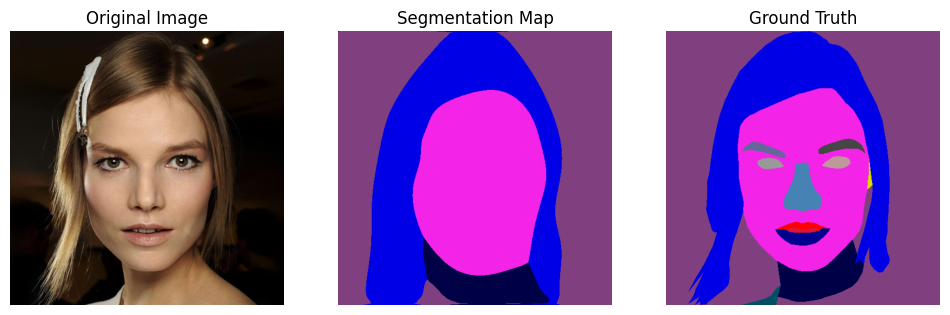

In [7]:

# Training loop
if MODE == 'train':
    train(model, train_loader, test_loader, criterion, optimizer)
elif MODE == 'test':
    test(model, test_loader)